In [1]:
from datetime import datetime
import tensorflow as tf
import importlib
import numpy as np
import pandas as pd
from datetime import datetime
now = str(datetime.now().date())

In [2]:
# import config 
import configs.config
importlib.reload(configs.config)
from configs.config import CFG
from utils import config
config = config.Config.from_json(CFG)

## Create Dataset

In [3]:
# create Train Series and Dataset 
import dataloader.dataloader
importlib.reload(dataloader.dataloader)
from dataloader.dataloader import Train_Series,Dataset
try: 
    del series,ds
except:
    pass
from dataloader.dataloader import Test_Series
try: 
    del test_series
except:
    pass

series = Train_Series(config.data,config.paths)
series.createSeries()
test_series = Test_Series(config.data,config.paths)
test_series.createSeries()
ds = Dataset(series,test_series)
ds.split_dataset()

X_train = ds.X_train
y_train = ds.y_train
X_test = ds.X_test
y_test = ds.y_test

print(X_train.shape)
print(X_test.shape)


(52, 5760, 4)
(3, 5760, 4)


In [11]:
# Generate the dataset windows
window_size = 150
batch_size = 32
shuffle_buffer_size = 1500
num_classes = 5
stride = 10

In [12]:
def windowed_dataset(series,  window_size, stride, batch_size, shuffle_buffer,num_classes):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      labels - contains 
      window_size (int) - the number of time steps to average
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    dataset = series.reshape(-1,series.shape[-1])
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(dataset)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=stride, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size))

    #
    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:,:-1], tf.one_hot(tf.dtypes.cast(window[:,-1],tf.int8),depth=num_classes)))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [13]:

dataset = windowed_dataset(ds.ds, window_size, stride, batch_size,shuffle_buffer_size,num_classes)
num_features = dataset.element_spec[0].shape[-1]



In [14]:
## assertion when the shuffle is disabled 
# for window in dataset:
#     window_numpy =window[0].numpy()
#     print((window_numpy[1,:-1,:] == window_numpy[0,1:,:]).all())
#     print((window_numpy[2,:-2,:] == window_numpy[0,2:,:]).all())
#     break

## Build the Model

In [15]:
# Build the Model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: x,input_shape=[window_size,num_features]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
  tf.keras.layers.Dense(num_classes,activation ='softmax'),
])

# Print the model summary
model_tune.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 150, 4)            0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 150, 64)          9472      
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 150, 64)          24832     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 150, 5)            325       
                                                                 
Total params: 34,629
Trainable params: 34,629
Non-trainable params: 0
_________________________________________________________________


## Tune the Learning Rate

In [16]:
# define epochs 
epochs = 40
#define initiial lr rate
init_lr_rate = 1e-6


In [125]:
# Reset states generated by Keras
tf.keras.backend.clear_session()
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: init_lr_rate * 10**(epoch / 10))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(
    #loss=tf.keras.losses.Huber(), optimizer=optimizer)
    optimizer = optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['categorical_accuracy'])


# Train the model
history = model_tune.fit(dataset, epochs=epochs, callbacks=[lr_schedule])

Epoch 1/40
936/936 [==============================] - 83s 83ms/step - loss: 0.9392 - categorical_accuracy: 0.7055 - lr: 1.0000e-06
Epoch 2/40
936/936 [==============================] - 83s 89ms/step - loss: 0.8947 - categorical_accuracy: 0.7276 - lr: 1.2589e-06
Epoch 3/40
936/936 [==============================] - 84s 89ms/step - loss: 0.8739 - categorical_accuracy: 0.7339 - lr: 1.5849e-06
Epoch 4/40
936/936 [==============================] - 80s 86ms/step - loss: 0.8553 - categorical_accuracy: 0.7348 - lr: 1.9953e-06
Epoch 5/40
936/936 [==============================] - 80s 86ms/step - loss: 0.8362 - categorical_accuracy: 0.7326 - lr: 2.5119e-06
Epoch 6/40
936/936 [==============================] - 82s 87ms/step - loss: 0.8164 - categorical_accuracy: 0.7304 - lr: 3.1623e-06
Epoch 7/40
936/936 [==============================] - 83s 89ms/step - loss: 0.7915 - categorical_accuracy: 0.7366 - lr: 3.9811e-06
Epoch 8/40
936/936 [==============================] - 83s 88ms/step - loss: 0.7734 

(1e-06, 0.01, 0.3, 0.6)

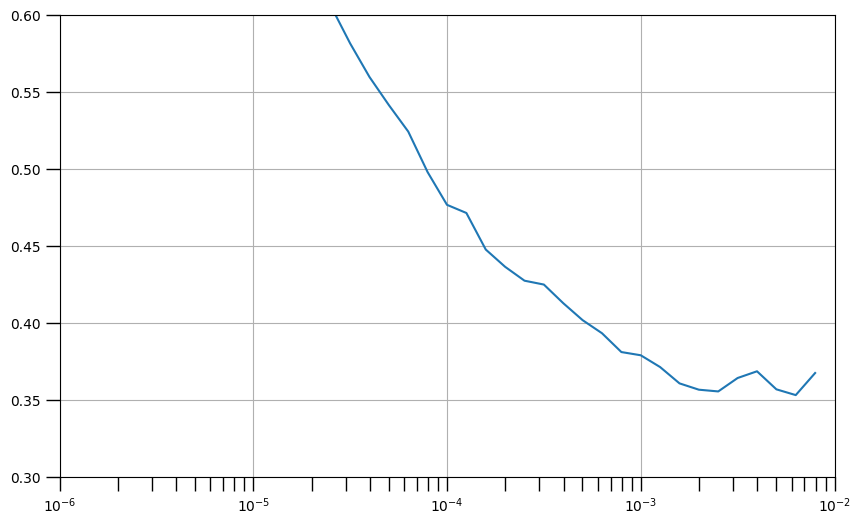

In [126]:
from matplotlib import pyplot as plt
# Define the learning rate array
lrs = init_lr_rate * (10 ** (np.arange(epochs) / 10))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([init_lr_rate, 1e-2, 0.3, 0.6])

In [17]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: x,input_shape=[window_size,num_features]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
  tf.keras.layers.Dense(num_classes,activation ='softmax'),
])

# Set the learning rate
learning_rate = 0.006
epochs = 40 

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Set the training parameters
model.compile(
    #loss=tf.keras.losses.Huber(), optimizer=optimizer)
    optimizer = optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['categorical_accuracy'])

# Train the model
history = model.fit(dataset,epochs=epochs)

Epoch 1/40
936/936 [==============================] - 79s 80ms/step - loss: 0.2280 - categorical_accuracy: 0.9072
Epoch 2/40
936/936 [==============================] - 110s 117ms/step - loss: 0.1832 - categorical_accuracy: 0.9257
Epoch 3/40
936/936 [==============================] - 135s 143ms/step - loss: 0.1849 - categorical_accuracy: 0.9243
Epoch 4/40
936/936 [==============================] - 80s 85ms/step - loss: 0.1827 - categorical_accuracy: 0.9255
Epoch 5/40
936/936 [==============================] - 79s 84ms/step - loss: 0.1799 - categorical_accuracy: 0.9280
Epoch 6/40
936/936 [==============================] - 85s 91ms/step - loss: 0.1777 - categorical_accuracy: 0.9277
Epoch 7/40
936/936 [==============================] - 81s 86ms/step - loss: 0.1802 - categorical_accuracy: 0.9288
Epoch 8/40
936/936 [==============================] - 78s 83ms/step - loss: 0.1706 - categorical_accuracy: 0.9333
Epoch 9/40
936/936 [==============================] - 80s 85ms/step - loss: 0.1662 -

<tf.Variable 'bidirectional_1/backward_lstm_1/lstm_cell_5/bias:0' shape=(128,) dtype=float32, numpy=
array([ 9.30302322e-01, -2.16376352e+00, -4.70180549e-02,  7.49051392e-01,
       -1.97009325e+00,  1.13248169e+00, -1.43588507e+00, -2.31660771e+00,
       -6.32236421e-01, -1.51253593e+00,  1.30738306e+00, -6.66644752e-01,
        7.31326580e-01,  1.52001634e-01,  4.24534559e-01, -1.14035308e+00,
       -1.32123697e+00, -1.80488372e+00, -2.51831627e+00,  5.54332316e-01,
       -2.30064586e-01,  7.23383963e-01, -1.58678198e+00, -1.00627430e-01,
       -1.41211760e+00, -1.51713085e+00, -8.75015497e-01, -5.19484472e+00,
       -1.37880254e+00, -2.13136292e+00, -8.19314659e-01, -1.38153374e+00,
       -4.75600332e-01,  2.44118428e+00,  2.18917155e+00,  1.98792434e+00,
        3.10235023e-01,  1.43037510e+00,  8.50903392e-01,  8.87495577e-02,
       -4.84056056e-01,  2.85588413e-01,  1.73714507e+00,  3.59346896e-01,
       -6.69232607e-02,  1.07970345e+00,  2.58274674e+00,  3.30978847e+00,

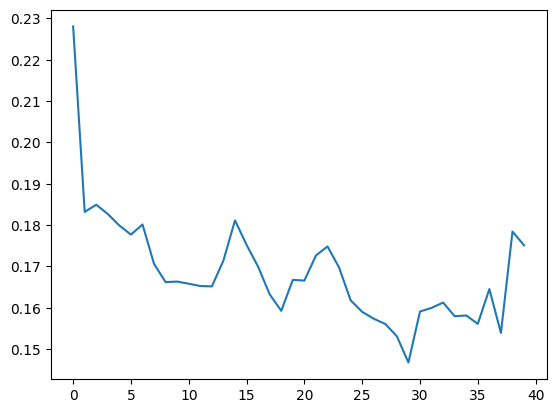

In [20]:
from matplotlib import pyplot as plt
plt.plot(history.history["loss"])

In [21]:
model_name = f"lstm_1x32_lr_{learning_rate}"
model_name
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "model/weights/cp-{model_name}-{epoch:04d}_{now}.ckpt"
# save weights 
model.save_weights(checkpoint_path.format(epoch=epochs,now=now,model_name=model_name))
#save model
models_path = "model/saved_models/{model_name}_{version}_{now}"
model.save(models_path.format(version = "v1", now = now,model_name=model_name))

INFO:tensorflow:Assets written to: model/saved_models/lstm_1x32_lr_0.006_v1_2023-11-29\assets


INFO:tensorflow:Assets written to: model/saved_models/lstm_1x32_lr_0.006_v1_2023-11-29\assets


In [22]:
def windowed_trainset(series,  window_size,  batch_size):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      labels - contains 
      window_size (int) - the number of time steps to average
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    dataset = series.reshape(-1,series.shape[-1])
    print(dataset.shape)

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    print(dataset)
      # Window the data but only take those with the specified size
    dataset = dataset.window(window_size,  drop_remainder=True)
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:,:-1], tf.one_hot(tf.dtypes.cast(window[:,-1],tf.int8),depth=3)))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

#dataset_test = windowed_trainset(ds.ds_test, window_size, stride, batch_size)

In [50]:
del test_series
test_series = Test_Series(config.data,config.paths)
test_series.createSeries()

In [63]:

from dataloader.dataloader import Serie
importlib.reload(dataloader.dataloader)
try: 
    del Serie
except:
    pass
from dataloader.dataloader import Serie

def predict(model,serie):
    x = serie.get_correct_slices()[:,:150,:]
    #x = windowed_trainset(x, window_size, stride, batch_size)
    y_pred = None

    #print(x.shape)
    try:
        y_pred = model.predict(x)
    except ValueError:
        #print(x.shape)
        print(x)

    
    #print(y_pred)
    #serie_events , raw_prediction = Serie.create_events(serie,y_pred)   
    serie.slice_pads = None
    serie_events  = Serie.create_events(serie,y_pred,only_top_score=False)  
    #return serie_events, raw_prediction
    return serie_events, y_pred

In [64]:
raw_predictions = {}
series_pred = np.array([])
y_pred = None
pred_start = False
for serie_id, serie in test_series.series.items():
    #serie_events, raw_predictions[serie_id] = predict(unet,serie)
    serie_events, y = predict(model,serie)
    print(serie_id)
    #print(serie_events)
    if pred_start == False:
        series_pred = y
        y_pred = serie_events
        pred_start = True
    else:
        series_pred = np.concatenate((series_pred, y))
        y_pred = pd.concat([y_pred, serie_events])


1/1 [==============================] - 0s 36ms/step


038441c925bb
1/1 [==============================] - 0s 29ms/step
03d92c9f6f8a 36
03d92c9f6f8a
1/1 [==============================] - 0s 29ms/step
0402a003dae9


In [ ]:
# define epochs 
epochs = 40
#define initiial lr rate
init_lr_rate = 1e-6


In [80]:
fig,ax = plt.subplot(series_pred[0])
for i in range(series_pred[0]):
    ax[i].plot(np.argmax(series_pred[i:i+1,:,-1],axis = 0,keepdims=True))

plt.show()

ValueError: Single argument to subplot must be a three-digit integer, not array([[3.75067295e-12, 5.96146345e-01, 1.68511072e-08, 4.02501792e-01,
        1.35180820e-03],
       [8.12957625e-14, 6.01475358e-01, 3.88207036e-06, 3.97951961e-01,
        5.68831689e-04],
       [2.56926671e-15, 7.84760714e-01, 7.13643615e-08, 2.15073451e-01,
        1.65726044e-04],
       [6.49082188e-13, 7.89836466e-01, 1.03422146e-07, 2.09968358e-01,
        1.95091547e-04],
       [1.02449061e-12, 7.71458328e-01, 4.66643911e-07, 2.28353396e-01,
        1.87810176e-04],
       [1.11941576e-12, 7.37035275e-01, 1.09537700e-06, 2.62809157e-01,
        1.54578593e-04],
       [5.73199084e-12, 7.78371751e-01, 8.87102942e-06, 2.21480742e-01,
        1.38663454e-04],
       [4.65151680e-13, 8.09640169e-01, 1.11593430e-07, 1.90171823e-01,
        1.87908328e-04],
       [6.51125584e-13, 8.24272156e-01, 1.65994365e-07, 1.75577670e-01,
        1.49924032e-04],
       [2.32269309e-13, 8.65311205e-01, 7.09752612e-07, 1.34608150e-01,
        7.99505433e-05],
       [8.11937831e-15, 8.71593595e-01, 5.89395333e-09, 1.28295019e-01,
        1.11363646e-04],
       [3.59382993e-15, 8.45626831e-01, 6.66406441e-09, 1.54234260e-01,
        1.38895542e-04],
       [1.07241518e-16, 7.10379958e-01, 2.51740087e-08, 2.89431244e-01,
        1.88738399e-04],
       [5.54524773e-15, 8.69857371e-01, 1.64629142e-07, 1.30002394e-01,
        1.39991098e-04],
       [1.24466735e-13, 8.47098470e-01, 4.54002566e-06, 1.52733475e-01,
        1.63489880e-04],
       [1.22420782e-15, 8.98198605e-01, 7.11906551e-08, 1.01655088e-01,
        1.46243197e-04],
       [1.44262033e-12, 9.40078676e-01, 1.16298679e-05, 5.98459728e-02,
        6.36946133e-05],
       [1.57191742e-11, 8.98178279e-01, 4.97177607e-05, 1.01704471e-01,
        6.75334668e-05],
       [4.69663533e-13, 9.56377625e-01, 2.18489916e-07, 4.36036214e-02,
        1.86397192e-05],
       [5.19441261e-12, 9.64123130e-01, 4.74995841e-06, 3.58590484e-02,
        1.31072775e-05],
       [8.12444487e-11, 9.75825727e-01, 5.91653452e-06, 2.41566859e-02,
        1.15890052e-05],
       [7.11769185e-11, 9.69079614e-01, 3.83411771e-06, 3.09040695e-02,
        1.24876578e-05],
       [1.31259226e-10, 9.67559934e-01, 6.09799190e-06, 3.24221887e-02,
        1.17614309e-05],
       [3.94462019e-10, 9.73629534e-01, 1.50350861e-05, 2.63453070e-02,
        1.01515579e-05],
       [9.40726053e-10, 9.60612059e-01, 4.12583940e-05, 3.93321477e-02,
        1.45317017e-05],
       [1.02034173e-10, 9.26792264e-01, 1.70607182e-05, 7.31685311e-02,
        2.21793998e-05],
       [8.42942524e-14, 9.31841969e-01, 5.47909735e-07, 6.81369901e-02,
        2.05524357e-05],
       [4.55731552e-17, 5.49690247e-01, 4.24912052e-08, 4.50305670e-01,
        3.97149006e-06],
       [5.01052070e-16, 6.70067549e-01, 2.23273810e-06, 3.29912335e-01,
        1.79103081e-05],
       [4.95938532e-16, 6.86612070e-01, 4.30092859e-06, 3.13350260e-01,
        3.32975178e-05],
       [8.16391213e-16, 7.05173314e-01, 5.92811375e-06, 2.94785112e-01,
        3.55255579e-05],
       [1.49924374e-14, 7.47970104e-01, 1.71656993e-05, 2.51988202e-01,
        2.45451483e-05],
       [8.80610282e-14, 7.72388577e-01, 3.29464747e-05, 2.27557883e-01,
        2.05902397e-05],
       [1.03026515e-13, 7.75026202e-01, 3.58019497e-05, 2.24916711e-01,
        2.12856139e-05],
       [1.06055491e-13, 7.74519026e-01, 3.65017622e-05, 2.25422755e-01,
        2.16746066e-05],
       [1.08995522e-13, 7.73795962e-01, 3.71151327e-05, 2.26145059e-01,
        2.19131780e-05],
       [1.11937606e-13, 7.72908449e-01, 3.76472490e-05, 2.27031812e-01,
        2.20918628e-05],
       [1.14782112e-13, 7.71871984e-01, 3.80603378e-05, 2.28067666e-01,
        2.22355920e-05],
       [1.17545256e-13, 7.70702004e-01, 3.83873339e-05, 2.29237273e-01,
        2.23553088e-05],
       [1.20288667e-13, 7.69429743e-01, 3.86495994e-05, 2.30509192e-01,
        2.24583619e-05],
       [1.22990133e-13, 7.68082619e-01, 3.88470216e-05, 2.31856108e-01,
        2.25473050e-05],
       [1.25650602e-13, 7.66672134e-01, 3.89967499e-05, 2.33266219e-01,
        2.26241064e-05],
       [1.28292383e-13, 7.65216708e-01, 3.91100257e-05, 2.34721392e-01,
        2.26916018e-05],
       [1.30918429e-13, 7.63730049e-01, 3.91913782e-05, 2.36208051e-01,
        2.27513829e-05],
       [1.33535449e-13, 7.62225270e-01, 3.92460970e-05, 2.37712651e-01,
        2.28053850e-05],
       [1.36147360e-13, 7.60697186e-01, 3.92887014e-05, 2.39240691e-01,
        2.28535391e-05],
       [1.38759813e-13, 7.59169400e-01, 3.93094233e-05, 2.40768373e-01,
        2.28980862e-05],
       [1.41375599e-13, 7.57635236e-01, 3.93218288e-05, 2.42302492e-01,
        2.29390625e-05],
       [1.43994707e-13, 7.56100655e-01, 3.93265909e-05, 2.43836999e-01,
        2.29771595e-05],
       [1.46636501e-13, 7.54570246e-01, 3.93282571e-05, 2.45367438e-01,
        2.30133082e-05],
       [1.49266274e-13, 7.53043652e-01, 3.93254631e-05, 2.46893972e-01,
        2.30457354e-05],
       [1.51913543e-13, 7.51525342e-01, 3.93193732e-05, 2.48412162e-01,
        2.30769165e-05],
       [1.54571627e-13, 7.50010788e-01, 3.93145274e-05, 2.49926776e-01,
        2.31059985e-05],
       [1.57239131e-13, 7.48509765e-01, 3.93031041e-05, 2.51427829e-01,
        2.31340546e-05],
       [1.59917964e-13, 7.47017741e-01, 3.92926377e-05, 2.52919883e-01,
        2.31606700e-05],
       [1.62608005e-13, 7.45535791e-01, 3.92822149e-05, 2.54401684e-01,
        2.31859249e-05],
       [1.65315624e-13, 7.44071364e-01, 3.92684778e-05, 2.55866081e-01,
        2.32107104e-05],
       [1.68033556e-13, 7.42617607e-01, 3.92557595e-05, 2.57319897e-01,
        2.32342572e-05],
       [1.70751596e-13, 7.41175413e-01, 3.92428337e-05, 2.58762121e-01,
        2.32564616e-05],
       [1.73499480e-13, 7.39747763e-01, 3.92327383e-05, 2.60189712e-01,
        2.32784369e-05],
       [1.76235017e-13, 7.38333762e-01, 3.92194488e-05, 2.61603624e-01,
        2.32986640e-05],
       [1.78995423e-13, 7.36932993e-01, 3.92084112e-05, 2.63004512e-01,
        2.33187766e-05],
       [1.81759311e-13, 7.35543787e-01, 3.91992289e-05, 2.64393657e-01,
        2.33375413e-05],
       [1.84540168e-13, 7.34175384e-01, 3.91861249e-05, 2.65762061e-01,
        2.33563860e-05],
       [1.87338914e-13, 7.32820690e-01, 3.91775429e-05, 2.67116785e-01,
        2.33744686e-05],
       [1.90141834e-13, 7.31484473e-01, 3.91644826e-05, 2.68453032e-01,
        2.33920891e-05],
       [1.92917324e-13, 7.30145931e-01, 3.91606882e-05, 2.69791484e-01,
        2.34069412e-05],
       [1.95860418e-13, 7.28867173e-01, 3.91485119e-05, 2.71070182e-01,
        2.34274848e-05],
       [1.98423743e-13, 7.27565825e-01, 3.91332906e-05, 2.72371560e-01,
        2.34311301e-05],
       [2.01275357e-13, 7.26258516e-01, 3.91366557e-05, 2.73678958e-01,
        2.34462223e-05],
       [2.04079998e-13, 7.24975765e-01, 3.91307694e-05, 2.74961710e-01,
        2.34594718e-05],
       [2.07119871e-13, 7.23744690e-01, 3.91213653e-05, 2.76192755e-01,
        2.34812705e-05],
       [2.09813287e-13, 7.22496450e-01, 3.91098001e-05, 2.77440876e-01,
        2.34878316e-05],
       [2.12911367e-13, 7.21301258e-01, 3.91007343e-05, 2.78636158e-01,
        2.35112038e-05],
       [2.15868312e-13, 7.20094740e-01, 3.90950881e-05, 2.79842734e-01,
        2.35276148e-05],
       [2.18656731e-13, 7.18855500e-01, 3.91084359e-05, 2.81081885e-01,
        2.35355783e-05],
       [2.21991086e-13, 7.17746735e-01, 3.91101275e-05, 2.82190651e-01,
        2.35607640e-05],
       [2.23959780e-13, 7.16573179e-01, 3.90861569e-05, 2.83364147e-01,
        2.35339739e-05],
       [2.27050082e-13, 7.15410888e-01, 3.91082976e-05, 2.84526497e-01,
        2.35507414e-05],
       [2.29993135e-13, 7.14272678e-01, 3.91100293e-05, 2.85664648e-01,
        2.35622083e-05],
       [2.32942219e-13, 7.13152289e-01, 3.91128233e-05, 2.86785066e-01,
        2.35730840e-05],
       [2.35895992e-13, 7.12046385e-01, 3.91170288e-05, 2.87890851e-01,
        2.35832431e-05],
       [2.38899232e-13, 7.10964322e-01, 3.91194662e-05, 2.88973033e-01,
        2.35947227e-05],
       [2.41914426e-13, 7.09898889e-01, 3.91233989e-05, 2.90038466e-01,
        2.36059623e-05],
       [2.44867874e-13, 7.08828807e-01, 3.91341528e-05, 2.91108549e-01,
        2.36137148e-05],
       [2.47829453e-13, 7.07779109e-01, 3.91453541e-05, 2.92158157e-01,
        2.36210799e-05],
       [2.50846517e-13, 7.06749916e-01, 3.91564463e-05, 2.93187261e-01,
        2.36298238e-05],
       [2.53861873e-13, 7.05735266e-01, 3.91685317e-05, 2.94201910e-01,
        2.36377928e-05],
       [2.56865438e-13, 7.04731405e-01, 3.91839385e-05, 2.95205861e-01,
        2.36444976e-05],
       [2.59906517e-13, 7.03743696e-01, 3.91984140e-05, 2.96193480e-01,
        2.36519718e-05],
       [2.62954263e-13, 7.02771485e-01, 3.92151087e-05, 2.97165722e-01,
        2.36589512e-05],
       [2.66027028e-13, 7.01813817e-01, 3.92319089e-05, 2.98123300e-01,
        2.36661290e-05],
       [2.69141724e-13, 7.00878501e-01, 3.92486581e-05, 2.99058616e-01,
        2.36742926e-05],
       [2.72179577e-13, 6.99934781e-01, 3.92728907e-05, 3.00002217e-01,
        2.36787237e-05],
       [2.75266138e-13, 6.99012935e-01, 3.92962684e-05, 3.00924063e-01,
        2.36842134e-05],
       [2.78406069e-13, 6.98113143e-01, 3.93184382e-05, 3.01823825e-01,
        2.36909982e-05],
       [2.81520114e-13, 6.97215915e-01, 3.93436640e-05, 3.02720994e-01,
        2.36959568e-05],
       [2.84757054e-13, 6.96359932e-01, 3.93638475e-05, 3.03577006e-01,
        2.37047461e-05],
       [2.87889477e-13, 6.95490241e-01, 3.93923001e-05, 3.04446697e-01,
        2.37092572e-05],
       [2.91006097e-13, 6.94622338e-01, 3.94259259e-05, 3.05314571e-01,
        2.37122131e-05],
       [2.94236396e-13, 6.93791807e-01, 3.94533272e-05, 3.06145012e-01,
        2.37185577e-05],
       [2.97450378e-13, 6.92963660e-01, 3.94847048e-05, 3.06973100e-01,
        2.37235927e-05],
       [3.00729087e-13, 6.92157209e-01, 3.95148418e-05, 3.07779551e-01,
        2.37302229e-05],
       [3.03932850e-13, 6.91342950e-01, 3.95519637e-05, 3.08593780e-01,
        2.37335425e-05],
       [3.07173666e-13, 6.90546751e-01, 3.95891257e-05, 3.09389949e-01,
        2.37375898e-05],
       [3.10381657e-13, 6.89745128e-01, 3.96331343e-05, 3.10191512e-01,
        2.37393542e-05],
       [3.13760167e-13, 6.88991845e-01, 3.96679316e-05, 3.10944766e-01,
        2.37463573e-05],
       [3.17054813e-13, 6.88224256e-01, 3.97120748e-05, 3.11712354e-01,
        2.37495533e-05],
       [3.20459669e-13, 6.87491357e-01, 3.97510557e-05, 3.12445134e-01,
        2.37558907e-05],
       [3.23754099e-13, 6.86738193e-01, 3.98011471e-05, 3.13198268e-01,
        2.37578079e-05],
       [3.27098374e-13, 6.86001062e-01, 3.98501033e-05, 3.13935339e-01,
        2.37603417e-05],
       [3.30627696e-13, 6.85310066e-01, 3.98918237e-05, 3.14626247e-01,
        2.37679196e-05],
       [3.34133898e-13, 6.84619784e-01, 3.99373967e-05, 3.15316528e-01,
        2.37741133e-05],
       [3.37609498e-13, 6.83928549e-01, 3.99867422e-05, 3.16007644e-01,
        2.37785989e-05],
       [3.41135784e-13, 6.83254063e-01, 4.00364770e-05, 3.16682070e-01,
        2.37842305e-05],
       [3.44488815e-13, 6.82544291e-01, 4.01007601e-05, 3.17391783e-01,
        2.37832810e-05],
       [3.48200445e-13, 6.81915343e-01, 4.01478756e-05, 3.18020731e-01,
        2.37924323e-05],
       [3.51769151e-13, 6.81257606e-01, 4.02064252e-05, 3.18678409e-01,
        2.37965178e-05],
       [3.55430746e-13, 6.80618823e-01, 4.02635706e-05, 3.19317162e-01,
        2.38025423e-05],
       [3.59059570e-13, 6.79983854e-01, 4.03253398e-05, 3.19952041e-01,
        2.38068387e-05],
       [3.62684627e-13, 6.79344296e-01, 4.03936720e-05, 3.20591480e-01,
        2.38095472e-05],
       [3.66612475e-13, 6.78768516e-01, 4.04471321e-05, 3.21167260e-01,
        2.38201501e-05],
       [3.70459224e-13, 6.78179145e-01, 4.05070095e-05, 3.21756542e-01,
        2.38278590e-05],
       [3.74258458e-13, 6.77583694e-01, 4.05754399e-05, 3.22351962e-01,
        2.38331286e-05],
       [3.78133749e-13, 6.77003443e-01, 4.06427353e-05, 3.22932124e-01,
        2.38395551e-05],
       [3.82045524e-13, 6.76432788e-01, 4.07119733e-05, 3.23502660e-01,
        2.38460525e-05],
       [3.85969848e-13, 6.75862670e-01, 4.07864245e-05, 3.24072719e-01,
        2.38517332e-05],
       [3.90012892e-13, 6.75315559e-01, 4.08581291e-05, 3.24619740e-01,
        2.38595330e-05],
       [3.94097949e-13, 6.74778521e-01, 4.09321037e-05, 3.25156659e-01,
        2.38673347e-05],
       [3.98216101e-13, 6.74247324e-01, 4.10077955e-05, 3.25687855e-01,
        2.38749908e-05],
       [4.02378136e-13, 6.73720598e-01, 4.10854409e-05, 3.26214343e-01,
        2.38828598e-05],
       [4.06558793e-13, 6.73192918e-01, 4.11680594e-05, 3.26741934e-01,
        2.38899738e-05],
       [4.10826565e-13, 6.72679424e-01, 4.12521149e-05, 3.27255428e-01,
        2.38978337e-05],
       [4.15211295e-13, 6.72188222e-01, 4.13354101e-05, 3.27746511e-01,
        2.39075689e-05],
       [4.19499884e-13, 6.71672344e-01, 4.14294118e-05, 3.28262299e-01,
        2.39133824e-05],
       [4.24035671e-13, 6.71195090e-01, 4.15177237e-05, 3.28739494e-01,
        2.39235233e-05],
       [4.28741867e-13, 6.70746922e-01, 4.15986760e-05, 3.29187542e-01,
        2.39369583e-05],
       [4.33304244e-13, 6.70266867e-01, 4.16944822e-05, 3.29667509e-01,
        2.39454348e-05],
       [4.37998867e-13, 6.69802785e-01, 4.17908886e-05, 3.30131501e-01,
        2.39554320e-05],
       [4.42782746e-13, 6.69348538e-01, 4.18870331e-05, 3.30585599e-01,
        2.39660258e-05],
       [4.47657943e-13, 6.68900609e-01, 4.19858261e-05, 3.31033379e-01,
        2.39772307e-05],
       [4.52510452e-13, 6.68443501e-01, 4.20933175e-05, 3.31490427e-01,
        2.39861765e-05],
       [4.57449887e-13, 6.67983294e-01, 4.22059020e-05, 3.31950605e-01,
        2.39947512e-05],
       [4.62707834e-13, 6.67566538e-01, 4.23083657e-05, 3.32367033e-01,
        2.40086374e-05],
       [4.67958571e-13, 6.67140186e-01, 4.24168466e-05, 3.32793385e-01,
        2.40207773e-05],
       [4.73212832e-13, 6.66682124e-01, 4.25393810e-05, 3.33251357e-01,
        2.40281042e-05],
       [4.78451480e-13, 6.66313648e-01, 4.25913931e-05, 3.33619744e-01,
        2.40376012e-05],
       [4.85212510e-13, 6.65721536e-01, 4.27447085e-05, 3.34211677e-01,
        2.40189893e-05],
       [4.93250243e-13, 6.67582929e-01, 4.11528708e-05, 3.32351774e-01,
        2.41274829e-05],
       [4.68572230e-13, 6.60547256e-01, 4.29567663e-05, 3.39387268e-01,
        2.25529966e-05]], dtype=float32)

<Figure size 640x480 with 0 Axes>

In [47]:
for serie in test_series.series.values():
    serie.decode_list = Serie.decode_list

In [49]:
test_series.series["038441c925bb"].decode_list

{1: 'wakeup', 2: 'onset', 3: 'onset', 4: 'wakeup'}

In [79]:
np.argmax(series_pred[0:1,:,-1],axis = 0,keepdims=True)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int64)

In [77]:
series_pred[0,:,-1]

array([1.35180820e-03, 5.68831689e-04, 1.65726044e-04, 1.95091547e-04,
       1.87810176e-04, 1.54578593e-04, 1.38663454e-04, 1.87908328e-04,
       1.49924032e-04, 7.99505433e-05, 1.11363646e-04, 1.38895542e-04,
       1.88738399e-04, 1.39991098e-04, 1.63489880e-04, 1.46243197e-04,
       6.36946133e-05, 6.75334668e-05, 1.86397192e-05, 1.31072775e-05,
       1.15890052e-05, 1.24876578e-05, 1.17614309e-05, 1.01515579e-05,
       1.45317017e-05, 2.21793998e-05, 2.05524357e-05, 3.97149006e-06,
       1.79103081e-05, 3.32975178e-05, 3.55255579e-05, 2.45451483e-05,
       2.05902397e-05, 2.12856139e-05, 2.16746066e-05, 2.19131780e-05,
       2.20918628e-05, 2.22355920e-05, 2.23553088e-05, 2.24583619e-05,
       2.25473050e-05, 2.26241064e-05, 2.26916018e-05, 2.27513829e-05,
       2.28053850e-05, 2.28535391e-05, 2.28980862e-05, 2.29390625e-05,
       2.29771595e-05, 2.30133082e-05, 2.30457354e-05, 2.30769165e-05,
       2.31059985e-05, 2.31340546e-05, 2.31606700e-05, 2.31859249e-05,
      